In [1]:
import skimage
import networkx as nx

/Users/eyal/anaconda3/envs/spatial/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.slices, rows, cols = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[self.ind, :, :])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind, :, :])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

In [3]:
lung_path = '../hubmap_data/lung_data/D175R.tiff'
landmark_path = '../hubmap_data/lung_data/D175R.fcsv'
output_path = "../hubmap_data/D175R_results.csv"

x_0 = 125
y_0 = -4
z_0 = 30.80993652534375

downsample_factor = 20

In [4]:
lung_mask = skimage.io.imread(lung_path)

In [5]:
lung_mask.shape

(824, 768, 768)

In [6]:
downsampled = skimage.transform.downscale_local_mean(lung_mask, factors = (downsample_factor, downsample_factor, downsample_factor), )

In [7]:
downsampled[downsampled > 0] = 1

In [8]:
downsampled[:, 31:, : ] = 0

In [9]:
shape_list = list(downsampled.shape)

In [10]:
#Swap axes
x_shape = shape_list[2]
z_shape = shape_list[0]

shape_list[0] = x_shape
shape_list[2] = z_shape

In [11]:
lung_graph = nx.grid_graph(dim = shape_list)

In [12]:
unaccecable_nodes = np.argwhere(np.logical_not(downsampled))

In [13]:
# Only leave connected cytoplasm
for pixel in unaccecable_nodes:
    lung_graph.remove_node(tuple(pixel))

In [14]:
import pandas
landmarks = pandas.read_csv(landmark_path, skiprows = 2)

In [15]:
x = landmarks.x.to_numpy()
y = landmarks.y.to_numpy()
z = landmarks.z.to_numpy()

# Origin for 205
# x_0 = 125
# y_0 = 23
# z_0 = 28.910

s_x = 0.325520833 * downsample_factor
s_y = 0.325520833 * downsample_factor
s_z = 0.330017090 * downsample_factor

x = -np.floor((x - x_0) / s_x)
y = -np.floor((y - y_0) / s_y)
z = np.floor((z - z_0) / s_z)

In [16]:
landmark_locations = np.column_stack((z,y,x))
landmark_locations = landmark_locations[0::3, :]

In [17]:
# Only take accurate landmarks 
landmark_locations

array([[39., 20., 17.],
       [31., 26., 25.],
       [ 9., 20.,  7.],
       [14., 11., 17.],
       [-2., 21., 29.],
       [-2., 26., 21.],
       [13., 14., 12.],
       [23., 30., 22.],
       [11., 16.,  5.],
       [22., 28., 10.]])

In [18]:
landmark_locations[1, :] = np.array([31.0, 26.0, 24.0])
landmark_locations[4, :] = np.array([0, 21.0, 28.0])
landmark_locations[5, :] = np.array([0, 26.0, 21.0])

In [19]:
distances = [nx.shortest_path_length(lung_graph, source = tuple(location.astype(np.int))) for location in landmark_locations]

In [20]:
allowable_space_distances = np.zeros_like(downsampled, dtype = "int")

for pixel in np.argwhere(downsampled):
    allowable_space_distances[tuple(pixel)] = distances[0].get(tuple(pixel), 100000)

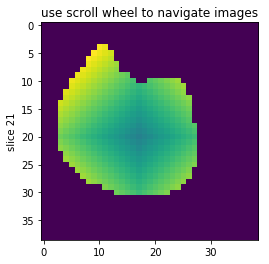

In [21]:
%matplotlib noteboo
fig, ax = plt.subplots(1, 1)
tracker = IndexTracker(ax, allowable_space_distances)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [22]:
len(distances)

10

In [23]:
import pandas as pd

In [24]:
distance_matrix = pd.DataFrame.from_dict(distances)

In [25]:
distance_matrix.to_csv(output_path)